In [1]:
from tree import Mbtree
import pickle
import gzip
from tqdm import tqdm

def calc_and_save_bestmoves_by_board(self, path):
    bestmoves_by_board = {}
    for node in tqdm(self.nodelist):
        txt = node.mb.board_to_str()
        if not txt in bestmoves_by_board.keys():
            bestmoves_by_board[txt] = node.bestmoves

    with gzip.open(path, "wb") as f:
        pickle.dump(bestmoves_by_board, f)
    
    return bestmoves_by_board

Mbtree.calc_and_save_bestmoves_by_board = calc_and_save_bestmoves_by_board  

In [2]:
def calc_and_save_bestmoves_and_score_by_board(self, path):
    bestmoves_and_score_by_board = {}
    for node in tqdm(self.nodelist):
        txt = node.mb.board_to_str()
        if not txt in bestmoves_and_score_by_board.keys():
            bestmoves_and_score_by_board[txt] = {
                "bestmoves": node.bestmoves,
                "score": node.score,
            }

    with gzip.open(path, "wb") as f:
        pickle.dump(bestmoves_and_score_by_board, f)
    
    return bestmoves_and_score_by_board

Mbtree.calc_and_save_bestmoves_and_score_by_board = calc_and_save_bestmoves_and_score_by_board  

In [3]:
mbtree = Mbtree.load("../data/aidata")
bestmoves_and_score_by_board = mbtree.calc_and_save_bestmoves_and_score_by_board(
       "../data/bestmoves_and_score_by_board.dat")
bftree_shortest_victory = Mbtree.load("../data/bftree_shortest_victory")
bestmoves_and_score_by_board_shortest_victory = \
    bftree_shortest_victory.calc_and_save_bestmoves_and_score_by_board(
       "../data/bestmoves_and_score_by_board_shortest_victory.dat")

100%|██████████| 549946/549946 [00:01<00:00, 461384.98it/s]


In [4]:
from tree import Node

def __init__(self, mb, parent=None, depth=0, bestmoves_and_score_by_board=None):
    self.id = Node.count
    Node.count += 1
    self.mb = mb
    self.parent = parent
    self.depth = depth
    self.children = []
    self.children_by_move = {}   
    if bestmoves_and_score_by_board is not None:
        bestmoves_and_score = bestmoves_and_score_by_board[self.mb.board_to_str()]
        self.bestmoves = bestmoves_and_score["bestmoves"]
        self.score = bestmoves_and_score["score"]
        
Node.__init__ = __init__

In [5]:
from copy import deepcopy

def calc_children(self, bestmoves_and_score_by_board=None):
    self.children = []
    for x, y in self.mb.calc_legal_moves():
        childmb = deepcopy(self.mb)
        childmb.move(x, y)
        self.insert(Node(childmb, parent=self, depth=self.depth + 1,
                         bestmoves_and_score_by_board=bestmoves_and_score_by_board))
        
Node.calc_children = calc_children

In [6]:
from marubatsu import Marubatsu

def create_subtree(self):
    bestmoves_and_score_by_board = self.subtree["bestmoves_and_score_by_board"]
    self.root = Node(Marubatsu(), bestmoves_and_score_by_board=bestmoves_and_score_by_board)
    
    depth = 0
    nodelist = [self.root]
    centermb = self.subtree["centermb"]
    centerdepth = centermb.move_count
    records = centermb.records
    maxdepth = self.subtree["maxdepth"]
    while len(nodelist) > 0:
        childnodelist = []
        for node in nodelist:
            if depth < centerdepth - 1:
                childmb = deepcopy(node.mb)
                x, y = records[depth + 1]
                childmb.move(x, y)
                childnode = Node(childmb, parent=node, depth=depth+1, 
                                 bestmoves_and_score_by_board=bestmoves_and_score_by_board)   
                node.insert(childnode)
                childnodelist.append(childnode)
            elif depth < maxdepth:
                node.calc_children(bestmoves_and_score_by_board=bestmoves_and_score_by_board)                   
                if depth == centerdepth - 1:
                    for move, childnode in node.children_by_move.items():
                        if move == records[depth + 1]:
                            self.centernode = childnode
                            childnodelist.append(self.centernode)
                        else:
                            if childnode.mb.status == Marubatsu.PLAYING:
                                childnode.children.append(None)
                else:
                    childnodelist += node.children
            else:
                if node.mb.status == Marubatsu.PLAYING:
                    childmb = deepcopy(node.mb)
                    board_str = node.mb.board_to_str()               
                    x, y = bestmoves_and_score_by_board[board_str]["bestmoves"][0]
                    childmb.move(x, y)
                    childnode = Node(childmb, parent=node, depth=depth+1, 
                                     bestmoves_and_score_by_board=bestmoves_and_score_by_board)   
                    node.insert(childnode)
                    childnodelist.append(childnode)
        nodelist = childnodelist
        depth += 1

    selectedmb = self.subtree["selectedmb"]
    self.selectednode = self.root
    for move in selectedmb.records[1:]:
        self.selectednode = self.selectednode.children_by_move[move]
        
Mbtree.create_subtree = create_subtree

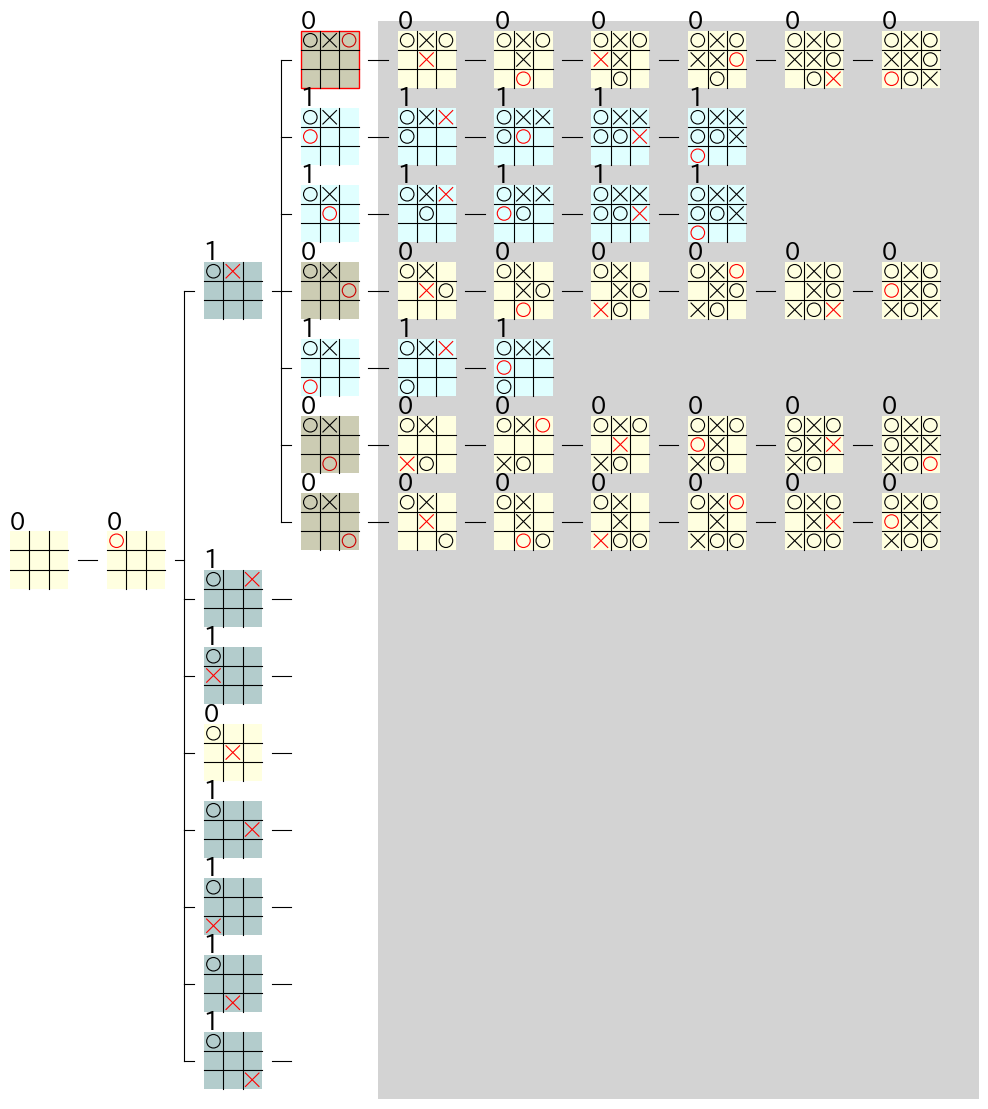

In [7]:
mb = Marubatsu()
mb.move(0, 0)
mb.move(1, 0)
mb2 = Marubatsu()
mb2.move(0, 0)
mb2.move(1, 0)
mb2.move(2, 0)
maxdepth = 3
subtree = Mbtree(subtree={"centermb": mb, "selectedmb": mb2, "maxdepth": maxdepth, 
                          "bestmoves_and_score_by_board": bestmoves_and_score_by_board})
centernode = subtree.centernode
selectednode = subtree.selectednode
subtree.draw_subtree(centernode=centernode, selectednode=selectednode, maxdepth=maxdepth,
                     show_bestmove=True)

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_subtree(self, centernode=None, selectednode=None, ax=None, anim_frame=None,
                    isscore=False, show_bestmove=False, show_score=True, size=0.25, lw=0.8, maxdepth=2):
    
    def calc_darkness(node):
        """ノードを表示する暗さを計算して返す."""
        
        if show_bestmove:
            if node.parent is None:
                return 0
            elif node.mb.last_move in node.parent.bestmoves:
                return 0
            else:
                return 0.2
            
        if anim_frame is None:
            return 0
        index = node.score_index if isscore else node.id
        return 0.5 if index > anim_frame else 0
    
    self.nodes_by_rect = {}

    if centernode is None:
        centernode = self.root
    self.calc_node_height(N=centernode, maxdepth=maxdepth)
    if show_bestmove:
        width = 5 * 10
    else:
        width = 5 * (maxdepth + 1)
    height = centernode.height
    parent = centernode.parent
    if parent is not None:
        height += (len(parent.children) - 1) * 4
        parent.height = height
    if ax is None:
        fig, ax = plt.subplots(figsize=(width * size, (height + 1) * size))
        ax.set_xlim(0, width)
        ax.set_ylim(-1, height)   
        ax.invert_yaxis()
        ax.axis("off")        
    
    if show_bestmove:
        bestx = 5 * maxdepth + 4
        bestwidth = 50 - bestx
        ax.add_artist(patches.Rectangle(xy=(bestx, -1), width=bestwidth,
                                        height=height + 1, fc="lightgray"))
    
    nodelist = [centernode]
    depth = centernode.depth
    while len(nodelist) > 0 and depth <= maxdepth:        
        dy = 0
        if parent is not None:
            dy = parent.children.index(centernode) * 4
        childnodelist = []
        for node in nodelist:
            if node is None:
                dy += 4
                childnodelist.append(None)
            else:
                dx = 5 * node.depth
                emphasize = node is selectednode
                darkness = calc_darkness(node)
                rect = node.draw_node(ax=ax, maxdepth=maxdepth, emphasize=emphasize, darkness=darkness,
                                    show_score=show_score, size=size, lw=lw, dx=dx, dy=dy)
                self.nodes_by_rect[rect] = node
                if show_bestmove and depth == maxdepth:
                    bestnode = node
                    while len(bestnode.bestmoves) > 0:
                        bestmove = bestnode.bestmoves[0]
                        bestnode = bestnode.children_by_move[bestmove]
                        dx = 5 * bestnode.depth
                        bestnode.height = 4
                        emphasize = bestnode is selectednode
                        rect = bestnode.draw_node(ax=ax, maxdepth=bestnode.depth, emphasize=emphasize,
                                                show_score=show_score, size=size, lw=lw, dx=dx, dy=dy)
                        self.nodes_by_rect[rect] = bestnode                                          
                    
                dy += node.height
                if len(node.children) > 0:  
                    childnodelist += node.children
                else:
                    childnodelist.append(None)
        depth += 1
        nodelist = childnodelist
        
    if parent is not None:
        dy = 0
        for sibling in parent.children:
            if sibling is not centernode:
                sibling.height = 4
                dx = 5 * sibling.depth
                darkness = calc_darkness(sibling)
                rect = sibling.draw_node(ax, maxdepth=sibling.depth, size=size, darkness=darkness,
                                        show_score=show_score, lw=lw, dx=dx, dy=dy)
                self.nodes_by_rect[rect] = sibling
            dy += sibling.height
        dx = 5 * parent.depth
        darkness = calc_darkness(parent)
        rect = parent.draw_node(ax, maxdepth=maxdepth, darkness=darkness, 
                                show_score=show_score, size=size, lw=lw, dx=dx, dy=0)
        self.nodes_by_rect[rect] = parent
    
        node = parent
        while node.parent is not None:
            node = node.parent
            node.height = height
            dx = 5 * node.depth
            darkness = calc_darkness(node)
            rect = node.draw_node(ax, maxdepth=node.depth, darkness=darkness,
                                show_score=show_score, size=size, lw=lw, dx=dx, dy=0)
            self.nodes_by_rect[rect] = node
            
Mbtree.draw_subtree = draw_subtree

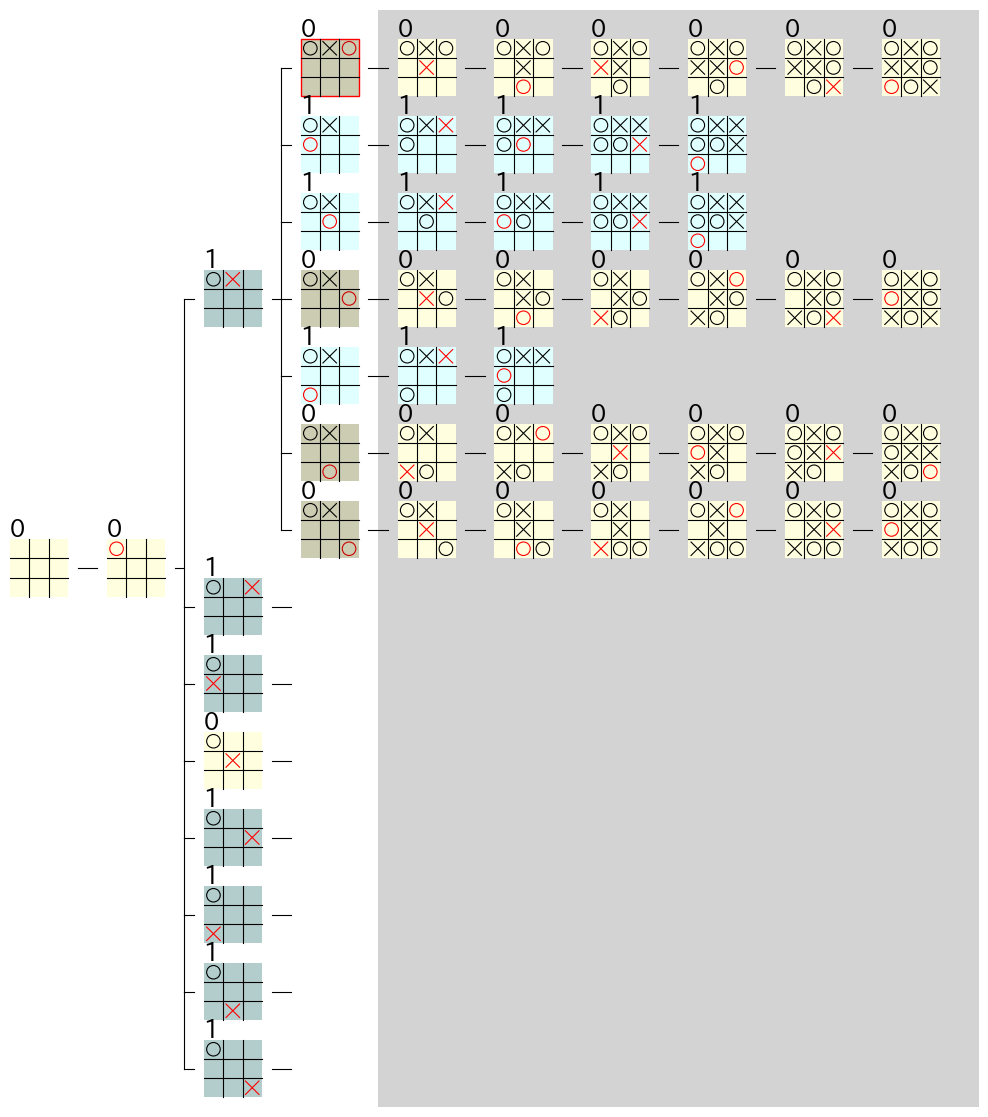

In [9]:
subtree = Mbtree(subtree={"centermb": mb, "selectedmb": mb2, "maxdepth": maxdepth, 
                          "bestmoves_and_score_by_board": bestmoves_and_score_by_board})
centernode = subtree.centernode
selectednode = subtree.selectednode
subtree.draw_subtree(centernode=centernode, selectednode=selectednode, maxdepth=maxdepth,
                     show_bestmove=True)

In [10]:
from tree import Mbtree_GUI

def __init__(self, bestmoves_and_score_by_board, show_score=True, size=0.15):   
    self.bestmoves_and_score_by_board = bestmoves_and_score_by_board
    self.show_score = show_score
    self.size = size
    self.width = 50
    self.height = 65
    self.selectednode = self.mbtree.root
    super(Mbtree_GUI, self).__init__()
    
Mbtree_GUI.__init__ = __init__

In [11]:
def update_gui(self):
    self.ax.clear()
    self.ax.set_xlim(-1, self.width - 1)
    self.ax.set_ylim(-1, self.height - 1)   
    self.ax.invert_yaxis()
    self.ax.axis("off")   
    
    if self.selectednode.depth <= 4:
        maxdepth = self.selectednode.depth + 1
    elif self.selectednode.depth == 5:
        maxdepth = 7
    else:
        maxdepth = 9
    centernode = self.selectednode
    while centernode.depth > 6:
        centernode = centernode.parent
    self.mbtree = Mbtree(subtree={"centermb": centernode.mb, "selectedmb": self.selectednode.mb, "maxdepth": maxdepth, 
                         "bestmoves_and_score_by_board": self.bestmoves_and_score_by_board})
    self.selectednode = self.mbtree.selectednode
    centernode = self.mbtree.centernode
    self.mbtree.draw_subtree(centernode=centernode, selectednode=self.selectednode,
                             show_bestmove=True, show_score=self.show_score,
                             ax=self.ax, maxdepth=maxdepth, size=self.size)
    
    disabled = self.selectednode.parent is None
    self.set_button_status(self.left_button, disabled=disabled)
    disabled = self.selectednode.depth >= 6 or len(self.selectednode.children) == 0
    self.set_button_status(self.right_button, disabled=disabled)
    disabled = self.selectednode.parent is None or self.selectednode.parent.children.index(self.selectednode) == 0
    self.set_button_status(self.up_button, disabled=disabled)
    disabled = self.selectednode.parent is None or self.selectednode.parent.children[-1] is self.selectednode
    self.set_button_status(self.down_button, disabled=disabled)
    self.set_button_color(self.score_button, value=self.show_score)
    
Mbtree_GUI.update_gui = update_gui

In [12]:
def __init__(self, bestmoves_and_score_by_board, show_score=True, size=0.15):   
    self.bestmoves_and_score_by_board = bestmoves_and_score_by_board
    self.show_score = show_score
    self.size = size
    self.width = 50
    self.height = 65
    self.selectednode = Node(Marubatsu())
    super(Mbtree_GUI, self).__init__()
    
Mbtree_GUI.__init__ = __init__

In [13]:
Mbtree_GUI(bestmoves_and_score_by_board)

AttributeError: 'Mbtree' object has no attribute 'centernode'

In [14]:
def create_subtree(self):
    bestmoves_and_score_by_board = self.subtree["bestmoves_and_score_by_board"]
    self.root = Node(Marubatsu(), bestmoves_and_score_by_board=bestmoves_and_score_by_board)
    
    depth = 0
    nodelist = [self.root]
    centermb = self.subtree["centermb"]
    centerdepth = centermb.move_count
    if centerdepth == 0:
        self.centernode = self.root
    records = centermb.records
    maxdepth = self.subtree["maxdepth"]
    while len(nodelist) > 0:
        childnodelist = []
        for node in nodelist:
            if depth < centerdepth - 1:
                childmb = deepcopy(node.mb)
                x, y = records[depth + 1]
                childmb.move(x, y)
                childnode = Node(childmb, parent=node, depth=depth+1, 
                                 bestmoves_and_score_by_board=bestmoves_and_score_by_board)   
                node.insert(childnode)
                childnodelist.append(childnode)
            elif depth < maxdepth:
                node.calc_children(bestmoves_and_score_by_board=bestmoves_and_score_by_board)                   
                if depth == centerdepth - 1:
                    for move, childnode in node.children_by_move.items():
                        if move == records[depth + 1]:
                            self.centernode = childnode
                            childnodelist.append(self.centernode)
                        else:
                            if childnode.mb.status == Marubatsu.PLAYING:
                                childnode.children.append(None)
                else:
                    childnodelist += node.children
            else:
                if node.mb.status == Marubatsu.PLAYING:
                    childmb = deepcopy(node.mb)
                    board_str = node.mb.board_to_str()               
                    x, y = bestmoves_and_score_by_board[board_str]["bestmoves"][0]
                    childmb.move(x, y)
                    childnode = Node(childmb, parent=node, depth=depth+1, 
                                     bestmoves_and_score_by_board=bestmoves_and_score_by_board)   
                    node.insert(childnode)
                    childnodelist.append(childnode)
        nodelist = childnodelist
        depth += 1

    selectedmb = self.subtree["selectedmb"]
    self.selectednode = self.root
    for move in selectedmb.records[1:]:
        self.selectednode = self.selectednode.children_by_move[move]
        
Mbtree.create_subtree = create_subtree

In [15]:
Mbtree_GUI(bestmoves_and_score_by_board)

In [16]:
Mbtree_GUI(bestmoves_and_score_by_board_shortest_victory)